# Missteering measurement using AC dipole excitation

- Just horizontal kicks
- TFB was off in these measurements

In [184]:
%run /eos/project/l/liu/Toolbox/myToolbox.py
print '---'
%run /eos/user/e/esenes/PS-analysis-tools/eTools.py
print '---'
sys.path.append('/eos/project/l/liu/Instrumentation/Scripts')
import metaclass

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.


Your platform is Linux-3.10.0-693.11.6.el7.x86_64-x86_64-with-redhat-6.9-Carbon
Your folder is /eos/user/e/esenes/PS-injection-steering/Data analysis/2018.07.02
Your IP is 172.17.0.14
2018-07-04 14:17:05
---
Version 0.1
Use at your own risk. Please report bugs to eugenio.senes@cern.ch
Fork it at https://gitlab.cern.ch/esenes/PS-analysis-tools
---


In [185]:
sys.path.append('/eos/project/l/liu/Instrumentation/Scripts')
import metaclass

# User inputs

In [186]:
folderPath = '/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.07.02'

matlabVars = ['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1', # Wirescanner 65
                'PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1',
                'PR_BWS_65_H_ROT.Acquisition.value.acqTimeInCycleSet1',
                'PR_BWS_85_V_ROT.Acquisition.value.projDataSet1', # Wirescanner 85
                'PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1',
                'PR_BWS_85_V_ROT.Acquisition.value.acqTimeInCycleSet1',
                'PR_BPM.AcquisitionOrbit.value.position', # BPMs
                'PR_BPM.AcquisitionTrajectoryBBB.value.position',
                'PR_BCT_ST.Samples.value.samples']



In [187]:
# let's start with the matlab data
files = sorted(glob.glob(folderPath+'/data/2018*.mat'))
print 'Found ' + str(len(files)) + ' data files'
print 'First: ' + files[0]
print 'End: ' + files[-1]

Found 215 data files
First: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.07.02/data/2018.07.02.16.19.35.398.mat
End: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.07.02/data/2018.07.02.20.32.16.081.mat


In [188]:
df1 = myToolbox.fromMatlabToDataFrame(files[101:116],matlabVars,verbose=False)
df1['label'] = 'ACD@C200'
df2 = myToolbox.fromMatlabToDataFrame(files[117:134],matlabVars,verbose=False)
df2['label'] = 'ACD@C200_2'
df3 = myToolbox.fromMatlabToDataFrame(files[135:150],matlabVars,verbose=False)
df3['label'] = 'C265Reference'
df4 = myToolbox.fromMatlabToDataFrame(files[151:166],matlabVars,verbose=False)
df4['label'] = 'ACD@C300'
df5 = myToolbox.fromMatlabToDataFrame(files[176:192],matlabVars,verbose=False)
df5['label'] = 'C400Reference'
df6 = myToolbox.fromMatlabToDataFrame(files[192:],matlabVars,verbose=False)
df6['label'] = 'C300Reference'

In [189]:
myDataFrame = pnd.concat([df1,df2,df3,df4,df5,df6])

# Data cleanup

In [190]:
myDataFrame = checkDuplicates(myDataFrame) # Drop double acquisitions from matlab
myDataFrame = checkBPMData(myDataFrame) # BPMs fault
# manual data drop
# myDataFrame = myDataFrame.drop(myDataFrame.loc['2017-11-14 17:58:45.100000'].name) # X wirescanner fault
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-07-02 18:36:10.300000'].name) # non-phys emittance

Dropped 5 duplicate(s)
---
BPM data ok
---


# Import the optics model

In [191]:
# get the optics functions from the model
optics = metaclass.twiss('/eos/user/e/esenes/AnalysisTools/Injection7_optics_Qx_0.21_Qy_0.23.outx')

Problem parsing: @ ORBIT_-CT        %le   -0.00000000

Going to be parsed as string
Problem persits, let's ignore it!


# Match the tomogram data

In [192]:
myDataFrame['deltaP_P_rms'] = 0.83e-3
myDataFrame['beta'] = 0.915095
myDataFrame['gamma'] =  2.479919

# Intensity

In [193]:
myDataFrame['Intensity'] = myDataFrame['PR_BCT_ST.Samples.value.samples']
myDataFrame['Intensity'] = myDataFrame['Intensity'].apply(lambda x: np.concatenate((np.zeros(100,dtype=float),x))) # start the acquisition from 0 ms

# Save the imported data

In [194]:
myDataFrame.to_pickle('imported_data_2018.07.02.pkl')

In [195]:
# myDataFrame=pnd.read_pickle('imported_data_2018.07.02.pkl')

# Losses ACD induced

38.180522/37.815364
Losses 0.96 %


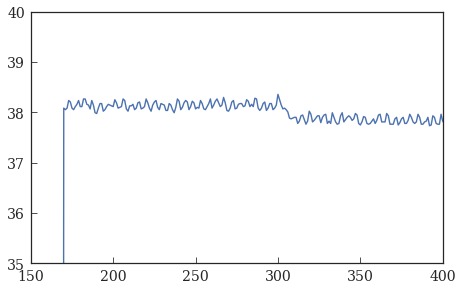

In [196]:
# what losses estimation does
plt.plot(myDataFrame['Intensity'].loc[myDataFrame['label'] == 'ACD@C300'].values[0])
I0 = np.mean(myDataFrame['Intensity'].loc[myDataFrame['label'] == 'ACD@C300'].values[0][260:265])
I1 = np.mean(myDataFrame['Intensity'].loc[myDataFrame['label'] == 'ACD@C300'].values[0][400:405])
print(str(I0)+'/'+str(I1))
print('Losses %.2f'%(100*(1-I1/I0))+' %')

plt.xlim(150,400);
plt.ylim(35,40);

In [197]:
myDataFrame['ACD Losses %'] = 0.

# process the various acquisitions
myDataFrame['ACD Losses %'].loc[myDataFrame['label'] == 'ACD@C300'] = myDataFrame['Intensity'].loc[myDataFrame['label'] == 'ACD@C300'].apply(lambda x: 100*(1-np.mean(x[400:405]) / np.mean(x[260:265])))   
myDataFrame['ACD Losses %'].loc[myDataFrame['label'] == 'C400Reference'] = myDataFrame['Intensity'].loc[myDataFrame['label'] == 'C400Reference'].apply(lambda x: 100*(1-np.mean(x[400:405]) / np.mean(x[260:265])))   
myDataFrame['ACD Losses %'].loc[myDataFrame['label'] == 'C300Reference'] = myDataFrame['Intensity'].loc[myDataFrame['label'] == 'C300Reference'].apply(lambda x: 100*(1-np.mean(x[400:405]) / np.mean(x[260:265])))   

myDataFrame['ACD Losses %'].loc[myDataFrame['label'] == 'ACD@C200'] = myDataFrame['Intensity'].loc[myDataFrame['label'] == 'ACD@C200'].apply(lambda x: 100*(1-np.mean(x[300:310]) / np.mean(x[180:190])))   
myDataFrame['ACD Losses %'].loc[myDataFrame['label'] == 'ACD@C200_2'] = myDataFrame['Intensity'].loc[myDataFrame['label'] == 'ACD@C200_2'].apply(lambda x: 100*(1-np.mean(x[300:310]) / np.mean(x[180:190])))   
myDataFrame['ACD Losses %'].loc[myDataFrame['label'] == 'C265Reference'] = myDataFrame['Intensity'].loc[myDataFrame['label'] == 'C265Reference'].apply(lambda x: 100*(1-np.mean(x[300:310]) / np.mean(x[180:190])))   


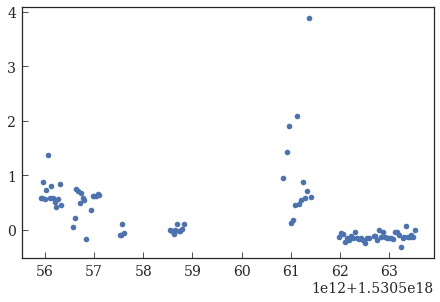

In [198]:
plt.plot(myDataFrame['ACD Losses %'],'o')

In [199]:
# limit the data to losses < 1%
myDataFrame = myDataFrame.loc[myDataFrame['ACD Losses %'] < 1.]

# Calculate wire scanner emittance
## X plane
### Traditional method

In [200]:
# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS65_position'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS65_position_idx'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS65_data'] = myDataFrame['BWS65_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS65_data'].iloc[r] = np.interp(pos, myDataFrame['BWS65_position'].iloc[r], myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS65_position_idx'].iloc[r]])  
    
#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_x'] = myDataFrame['BWS65_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_x'] = myDataFrame['WS_fit_results_x'].apply(lambda x: x[0][-1])


In [201]:
# Emittance calculation
myDataFrame['WS_emittance_x'] = np.nan
myDataFrame['WS_geom_emittance_x'] = np.nan

for n in range(len(myDataFrame)):
    myDataFrame['WS_emittance_x'].iloc[n] = normalised_emittance('65H',myDataFrame['WS_sigma_x'].values[n],dp=myDataFrame['deltaP_P_rms'].values[n])
    myDataFrame['WS_geom_emittance_x'].iloc[n] = myDataFrame['WS_emittance_x'].iloc[n]/(myDataFrame['beta'].iloc[n]*myDataFrame['gamma'].iloc[n])

## Y plane

In [202]:
# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS85_position'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS85_position_idx'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS85_data'] = myDataFrame['BWS85_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS85_data'].iloc[r] = np.interp(pos, myDataFrame['BWS85_position'].iloc[r], myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS85_position_idx'].iloc[r]])  

#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_y'] = myDataFrame['BWS85_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_y'] = myDataFrame['WS_fit_results_y'].apply(lambda x: x[0][-1])

In [203]:
# Emittance calculation
myDataFrame['WS_emittance_y'] = myDataFrame['WS_sigma_y'].apply(lambda x: normalised_emittance('85V',x))

myDataFrame['WS_geom_emittance_y'] = np.nan
for n in range(len(myDataFrame)):
    myDataFrame['WS_geom_emittance_y'].iloc[n] = myDataFrame['WS_emittance_y'].iloc[n]/(myDataFrame['beta'].iloc[n]*myDataFrame['gamma'].iloc[n])

## Calculate average emittance per measurement point

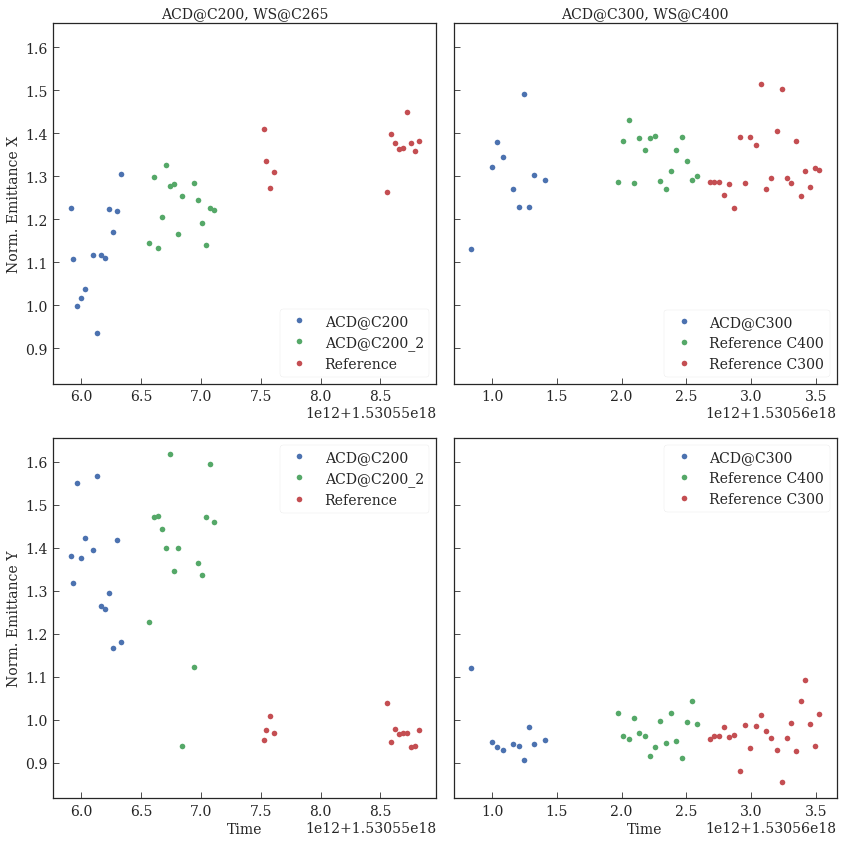

In [204]:
fig, ax = plt.subplots(2,2,figsize=(12,12), sharey=True)

# ACD@C200
emiC200 = myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'ACD@C200']
ax[0,0].plot(emiC200,'o',label = 'ACD@C200')

emiC200_2 = myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'ACD@C200_2']
ax[0,0].plot(emiC200_2,'o',label = 'ACD@C200_2')

refC265 = myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'C265Reference']
ax[0,0].plot(refC265,'o',label = 'Reference')

ax[0,0].set_title('ACD@C200, WS@C265')
ax[0,0].set_ylabel('Norm. Emittance X')
ax[0,0].legend(frameon=True,loc=4)

emiC200 = myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'ACD@C200']
ax[1,0].plot(emiC200,'o',label = 'ACD@C200')

emiC200_2 = myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'ACD@C200_2']
ax[1,0].plot(emiC200_2,'o',label = 'ACD@C200_2')

refC265 = myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'C265Reference']
ax[1,0].plot(refC265,'o',label = 'Reference')

ax[1,0].set_xlabel('Time')
ax[1,0].set_ylabel('Norm. Emittance Y')
ax[1,0].legend(frameon=True)


# ACD@C300
emiC300 = myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'ACD@C300']
ax[0,1].plot(emiC300,'o',label = 'ACD@C300')

refC400 = myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'C400Reference']
ax[0,1].plot(refC400,'o',label = 'Reference C400')

refC300 = myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'C300Reference']
ax[0,1].plot(refC300,'o',label = 'Reference C300')

ax[0,1].set_title('ACD@C300, WS@C400')
ax[0,1].legend(frameon=True,loc=4)

emiC300 = myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'ACD@C300']
ax[1,1].plot(emiC300,'o',label = 'ACD@C300')

refC400 = myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'C400Reference']
ax[1,1].plot(refC400,'o',label = 'Reference C400')

refC300 = myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'C300Reference']
ax[1,1].plot(refC300,'o',label = 'Reference C300')

ax[1,1].set_xlabel('Time')
ax[1,1].legend(frameon=True)


fig.tight_layout()
plt.savefig('emi_all.eps', format='eps', dpi=100)

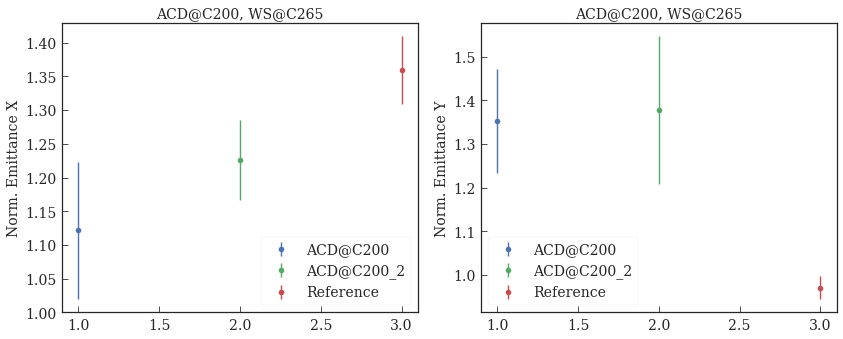

In [205]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

# ACD@C200
emiC200 = np.mean(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'ACD@C200'])
emiC200_std = np.std(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'ACD@C200'])
ax[0].errorbar(1,emiC200, fmt='o', yerr=emiC200_std, label = 'ACD@C200')

emiC200_2 = np.mean(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'ACD@C200_2'])
emiC200_2_std = np.std(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'ACD@C200_2'])

ax[0].errorbar(2, emiC200_2, yerr=emiC200_2_std, fmt='o', label = 'ACD@C200_2')

refC265 = np.mean(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'C265Reference'])
refC265_std = np.std(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'C265Reference'])

ax[0].errorbar(3,refC265,yerr=refC265_std, fmt='o', label = 'Reference')

ax[0].set_title('ACD@C200, WS@C265')
ax[0].set_ylabel('Norm. Emittance X')
ax[0].legend(frameon=True,loc=4)

emiC200 = np.mean(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'ACD@C200'])
emiC200_std = np.std(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'ACD@C200'])
ax[1].errorbar(1,emiC200, fmt='o', yerr=emiC200_std, label = 'ACD@C200')

emiC200_2 = np.mean(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'ACD@C200_2'])
emiC200_2_std = np.std(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'ACD@C200_2'])

ax[1].errorbar(2, emiC200_2, yerr=emiC200_2_std, fmt='o', label = 'ACD@C200_2')

refC265 = np.mean(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'C265Reference'])
refC265_std = np.std(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'C265Reference'])

ax[1].errorbar(3,refC265,yerr=refC265_std, fmt='o', label = 'Reference')

ax[1].set_title('ACD@C200, WS@C265')
ax[1].set_ylabel('Norm. Emittance Y')
ax[1].legend(frameon=True,loc=3)

fig.tight_layout()
plt.savefig('emi_ACD@C200.eps', format='eps', dpi=100)

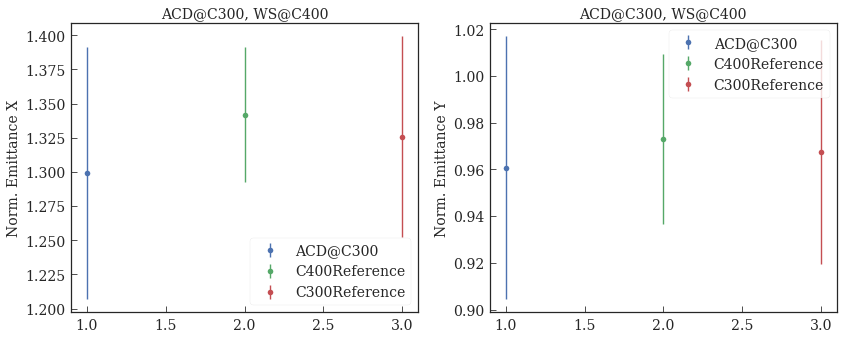

In [206]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

# ACD@C200
emiC200 = np.mean(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'ACD@C300'])
emiC200_std = np.std(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'ACD@C300'])
ax[0].errorbar(1,emiC200, fmt='o', yerr=emiC200_std, label = 'ACD@C300')

emiC200_2 = np.mean(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'C400Reference'])
emiC200_2_std = np.std(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'C400Reference'])

ax[0].errorbar(2, emiC200_2, yerr=emiC200_2_std, fmt='o', label = 'C400Reference')

refC265 = np.mean(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'C300Reference'])
refC265_std = np.std(myDataFrame['WS_emittance_x'].loc[myDataFrame['label'] == 'C300Reference'])

ax[0].errorbar(3,refC265,yerr=refC265_std, fmt='o', label = 'C300Reference')

ax[0].set_title('ACD@C300, WS@C400')
ax[0].set_ylabel('Norm. Emittance X')
ax[0].legend(frameon=True,loc=4)

emiC200 = np.mean(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'ACD@C300'])
emiC200_std = np.std(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'ACD@C300'])
ax[1].errorbar(1,emiC200, fmt='o', yerr=emiC200_std, label = 'ACD@C300')

emiC200_2 = np.mean(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'C400Reference'])
emiC200_2_std = np.std(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'C400Reference'])

ax[1].errorbar(2, emiC200_2, yerr=emiC200_2_std, fmt='o', label = 'C400Reference')

refC265 = np.mean(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'C300Reference'])
refC265_std = np.std(myDataFrame['WS_emittance_y'].loc[myDataFrame['label'] == 'C300Reference'])

ax[1].errorbar(3,refC265,yerr=refC265_std, fmt='o', label = 'C300Reference')

ax[1].set_title('ACD@C300, WS@C400')
ax[1].set_ylabel('Norm. Emittance Y')
ax[1].legend(frameon=True)

fig.tight_layout()
plt.savefig('emi_ACD@C300.eps', format='eps', dpi=100)

# BPMs

In [207]:
# BPMs
#add field for the first two turns and splitting x and y pickups
myDataFrame['BPMx'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[0:43,:])
myDataFrame['BPMy'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[-43:,:])

In [208]:
# calculate the max oscillation amplitude from the mean value at BPM03
myDataFrame['Max amplitude X'] = myDataFrame['BPMx'].apply(lambda x: np.max(x[1,:])-np.mean(x[1,:]) )
myDataFrame['Max amplitude Y'] = myDataFrame['BPMy'].apply(lambda x: np.max(x[1,:])-np.mean(x[1,:]) )

print('average max amplitude at ACD@C200 '+str(np.mean(myDataFrame['Max amplitude X'].loc[myDataFrame['label'] == 'ACD@C200']))+str(' mm'))
print('average max amplitude at ACD@C200_2 '+str(np.mean(myDataFrame['Max amplitude X'].loc[myDataFrame['label'] == 'ACD@C200_2']))+str(' mm'))
print('average max amplitude at ACD@C300 '+str(np.mean(myDataFrame['Max amplitude X'].loc[myDataFrame['label'] == 'ACD@C300']))+str(' mm'))

average max amplitude at ACD@C200 3.53461692308 mm
average max amplitude at ACD@C200_2 2.19667866667 mm
average max amplitude at ACD@C300 4.667948 mm


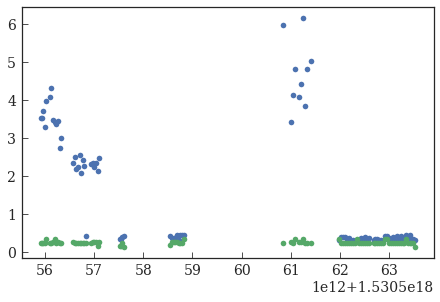

In [209]:
plt.plot(myDataFrame['Max amplitude X'],'o')
plt.plot(myDataFrame['Max amplitude Y'],'o')